<a href="https://colab.research.google.com/github/MdShahadatHossainbd/ML/blob/master/Transfer_learning_and_fine_tuning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q tf-nightly


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

Data preprocessing

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


68608000/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [6]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

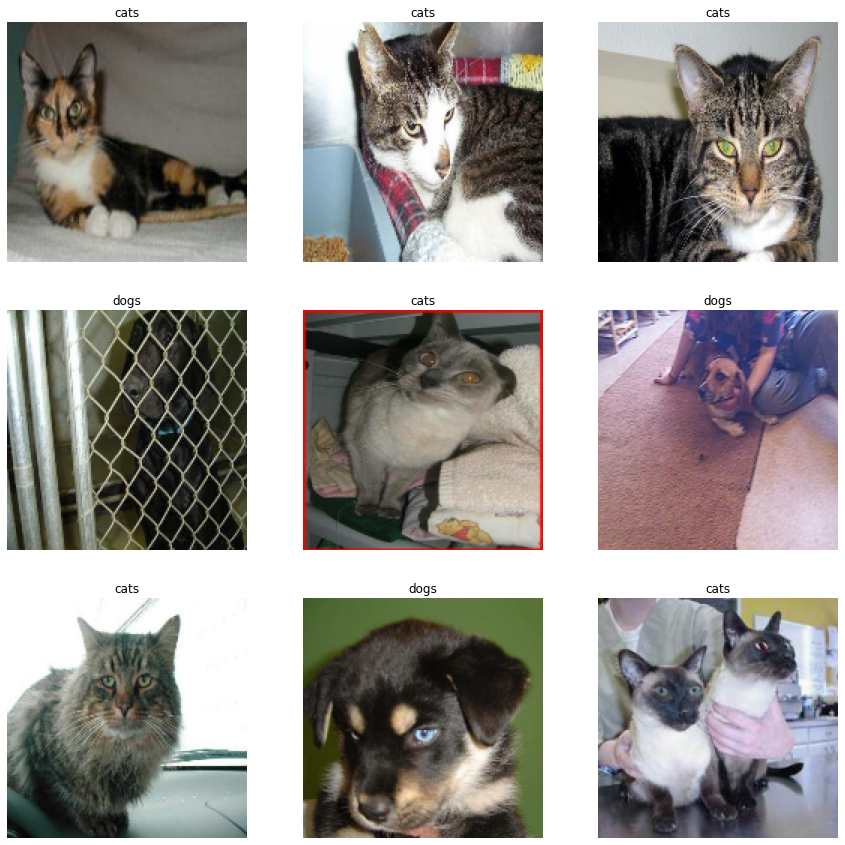

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(15, 15))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 21
Number of test batches: 5


Configure the dataset for performance

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Use data augmentation

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


Let's repeatedly apply these layers to the same image and see the result.

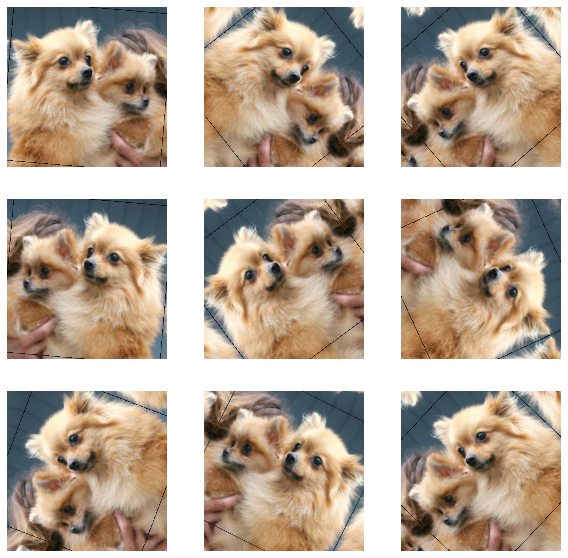

In [17]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


Rescale pixel values

In [19]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [21]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Create the base model from the pre-trained convnets

In [22]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [23]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


Feature extraction

Freeze the convolutional base

In [24]:
base_model.trainable = False

In [25]:
# Let's take a look at the base model architecture
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Add a classification head

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [27]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


In [29]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


Compile the model

In [30]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [31]:
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [32]:
len(model.trainable_variables)


2

In [33]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


21/21 [==============================] - 16s 627ms/step - loss: 0.8383 - accuracy: 0.4940


In [34]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 0.84
initial accuracy: 0.46


In [35]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/10
63/63 [==============================] - 62s 941ms/step - loss: 0.7671 - accuracy: 0.5555 - val_loss: 0.5896 - val_accuracy: 0.6204
Epoch 2/10
63/63 [==============================] - 60s 946ms/step - loss: 0.5562 - accuracy: 0.6875 - val_loss: 0.4385 - val_accuracy: 0.7238
Epoch 3/10
63/63 [==============================] - 61s 962ms/step - loss: 0.4499 - accuracy: 0.7505 - val_loss: 0.3526 - val_accuracy: 0.7762
Epoch 4/10
63/63 [==============================] - 61s 970ms/step - loss: 0.3793 - accuracy: 0.8170 - val_loss: 0.2866 - val_accuracy: 0.8426
Epoch 5/10
63/63 [==============================] - 64s 1s/step - loss: 0.3442 - accuracy: 0.8385 - val_loss: 0.2436 - val_accuracy: 0.8843
Epoch 6/10
63/63 [==============================] - 63s 995ms/step - loss: 0.3057 - accuracy: 0.8530 - val_loss: 0.2116 - val_accuracy: 0.9012
Epoch 7/10
63/63 [==============================] - 62s 977ms/step - loss: 0.2771 - accuracy: 0.8715 - val_loss: 0.1895 - val_accuracy: 0.9120
Ep

Learning curves

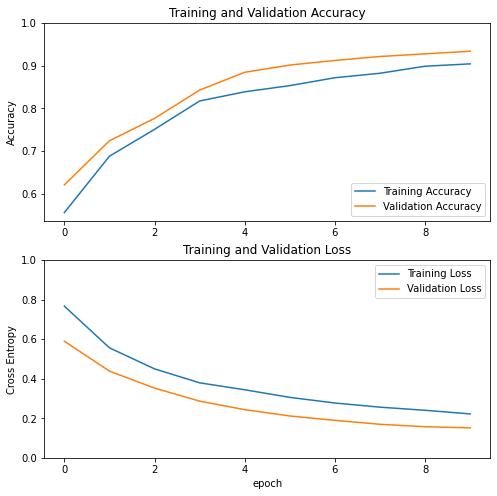

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Fine tuning

Un-freeze the top layers of the model

In [37]:
base_model.trainable = True


In [38]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  154


Compile the model

In [40]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])


In [41]:
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [42]:
len(model.trainable_variables)


56

Continue training the model

In [43]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20
63/63 [==============================] - 91s 1s/step - loss: 0.1838 - accuracy: 0.9226 - val_loss: 0.0787 - val_accuracy: 0.9738
Epoch 11/20
63/63 [==============================] - 87s 1s/step - loss: 0.1270 - accuracy: 0.9485 - val_loss: 0.0588 - val_accuracy: 0.9815
Epoch 12/20
63/63 [==============================] - 88s 1s/step - loss: 0.1231 - accuracy: 0.9478 - val_loss: 0.0543 - val_accuracy: 0.9799
Epoch 13/20
63/63 [==============================] - 87s 1s/step - loss: 0.0964 - accuracy: 0.9553 - val_loss: 0.0454 - val_accuracy: 0.9846
Epoch 14/20
63/63 [==============================] - 90s 1s/step - loss: 0.0831 - accuracy: 0.9686 - val_loss: 0.0405 - val_accuracy: 0.9861
Epoch 15/20
63/63 [==============================] - 88s 1s/step - loss: 0.0867 - accuracy: 0.9633 - val_loss: 0.0354 - val_accuracy: 0.9830
Epoch 16/20
63/63 [==============================] - 87s 1s/step - loss: 0.0722 - accuracy: 0.9680 - val_loss: 0.0548 - val_accuracy: 0.9815
Epoch 17/20
6

In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


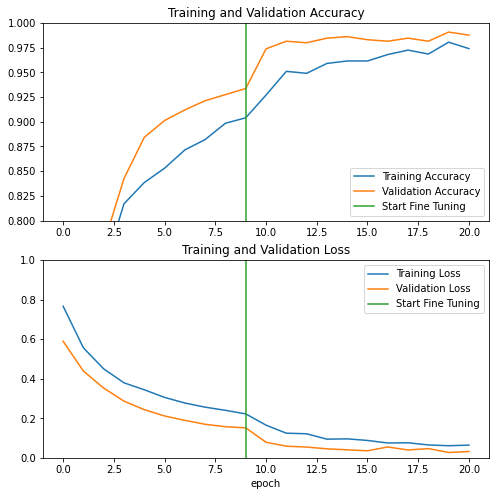

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Evaluation and prediction

In [46]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


5/5 [==============================] - 4s 612ms/step - loss: 0.0098 - accuracy: 1.0000
Test accuracy : 1.0


Predictions:
 [1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 0]
Labels:
 [1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 0]


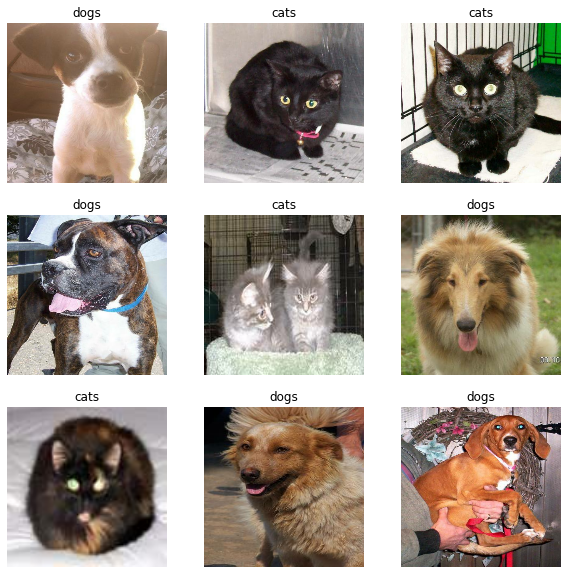

In [47]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
